# w261 Final Project - Clickthrough Rate Prediction


In [16]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import sys
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoderEstimator, OneHotEncoderModel
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, Imputer, VectorAssembler, SQLTransformer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
import pyspark
conf = pyspark.SparkConf().setAll([ ('spark.executor.pyspark.memory', '5g'), ('spark.driver.memory','5g')])
sc = pyspark.SparkContext(conf=conf)
# sqlContext = SQLContext(sc)
# 
# sc = SparkContext(appName="Final_Project")
sqlContext = SQLContext(sc)

In [5]:
# start Spark Session
app_name = "final_project_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

In [6]:
spark

In [7]:
sc._conf.getAll()

[('spark.app.name', 'final_project_notebook'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.driver.port', '40843'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.memory', '5g'),
 ('spark.app.id', 'local-1574833678834'),
 ('spark.executor.pyspark.memory', '5g'),
 ('spark.driver.host', 'docker.w261'),
 ('spark.ui.showConsoleProgress', 'true')]

In [8]:
start = time.time()
trainDF = sqlContext.read.parquet('train_for_model.parquet')
testDF = sqlContext.read.parquet('test_for_model.parquet')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 7.598312854766846 seconds


In [9]:
type(trainDF)

pyspark.sql.dataframe.DataFrame

In [10]:
trainDF.count()

45840617

In [11]:
trainDF.take(1)

[Row(y=0.0, features=SparseVector(283161, {0: 0.5025, 1: 0.0153, 2: 0.2325, 3: 1.9275, 4: 0.0427, 5: 0.3443, 7: 2.4573, 8: 0.2506, 9: 1.2213, 11: 0.3653, 12: 2.2304, 14: 1.0, 2187: 1.0, 2236: 1.0, 145128: 1.0, 157289: 1.0, 157291: 1.0, 157923: 1.0, 157949: 1.0, 157963: 1.0, 158021: 1.0, 172979: 1.0, 173043: 1.0, 176174: 1.0, 176232: 1.0, 181880: 1.0, 182447: 1.0, 182456: 1.0, 182467: 1.0, 182469: 1.0, 183942: 1.0, 189578: 1.0, 189885: 1.0, 189987: 1.0, 190008: 1.0, 190142: 1.0}))]

In [12]:
sampleDF = trainDF.sample(False, 0.001, seed=1234) # Approximately 45000 records

In [13]:
type(sampleDF)

pyspark.sql.dataframe.DataFrame

In [14]:
sampleDF.count()

45634

In [15]:
sampleDF.take(1)

[Row(y=0.0, features=SparseVector(283161, {1: 0.1584, 2: 0.0028, 3: 0.6425, 4: 0.019, 5: 0.7891, 6: 0.0155, 7: 1.7381, 8: 0.3666, 10: 0.1966, 11: 0.3653, 12: 0.3485, 13: 1.0, 2185: 1.0, 2202: 1.0, 144904: 1.0, 157289: 1.0, 157291: 1.0, 157923: 1.0, 157959: 1.0, 157964: 1.0, 157973: 1.0, 158079: 1.0, 172974: 1.0, 173016: 1.0, 176177: 1.0, 176213: 1.0, 181887: 1.0, 182448: 1.0, 182457: 1.0, 182465: 1.0, 182469: 1.0, 183974: 1.0, 189578: 1.0, 189882: 1.0, 189986: 1.0, 190009: 1.0, 190216: 1.0}))]

In [17]:
# Generate 80/20 (pseudo)random train/test split 
# start = time.time()
trainDF, validDF = sampleDF.randomSplit([0.8,0.2], seed = 1)
# print(f"\n... Executed in {time.time() - start} seconds")

In [18]:
print(f"Assigned {trainDF.count()} for training. Assigned {validDF.count()} for Validation.")

Assigned 36488 for training. Assigned 9146 for Validation.


In [24]:
# Train a DecisionTree model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
model = DecisionTree.trainClassifier(trainDF, numClasses=2, categoricalFeaturesInfo="features",
                                     impurity='Entropy', maxDepth=5, maxBins=32)

AssertionError: the data should be RDD of LabeledPoint

In [ ]:
# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(
    lambda lp: lp[0] != lp[1]).count() / float(testData.count())
print('Test Error = ' + str(testErr))
print('Learned classification tree model:')
print(model.toDebugString())

In [ ]:
# Save and load model
model.save(sc, "target/tmp/myDecisionTreeClassificationModel")
sameModel = DecisionTreeModel.load(sc, "target/tmp/myDecisionTreeClassificationModel")

In [10]:
dataset_size = trainDF.count()
numPositives = trainDF.select("y").where('y == 1').count()
per_ones = (float(numPositives) / float(dataset_size)) * 100
numNegatives = float(dataset_size - numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 933
Percentage of ones are 25.561643835616437


In [ ]:
# sc = spark.sparkContext
# sqlContext = SQLContext(sc)

In [ ]:
trainDF.take(1)

In [9]:
start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol='y', maxIter=10, regParam=1)
lr_model = lr.fit(trainDF)
lr_train_predictions = lr_model.transform(trainDF)
lr_valid_predictions = lr_model.transform(validDF)

print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 167.19526958465576 seconds


In [12]:
start = time.time()
lr_evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction",metricName="areaUnderPR")

trainAUPR = lr_evaluator.evaluate(lr_train_predictions)
validAUPR = lr_evaluator.evaluate(lr_valid_predictions)
print(f"Area Under Precision Recall Curve on Train data = {trainAUPR}")
print(f"Area Under Precision Recall Curve on Validation data = {validAUPR}")
print(f"\n... Executed in {time.time() - start} seconds")

Area Under Precision Recall Curve on Train data = 0.8436236033417023
Area Under Precision Recall Curve on Validation data = 0.40998110416147887

... Executed in 193.11019563674927 seconds


In [ ]:
start = time.time()
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(cvModel.bestModel.stages[-1].summary.roc.select('FPR').collect(),
         cvModel.bestModel.stages[-1].summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print(f"\n... Executed in {time.time() - start} seconds")

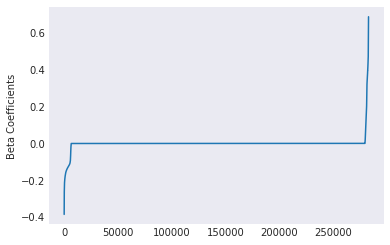

In [13]:
beta = np.sort(lr_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [18]:
beta

array([-0.38513581, -0.37193071, -0.35527042, ...,  0.66618992,
        0.66691965,  0.68822023])

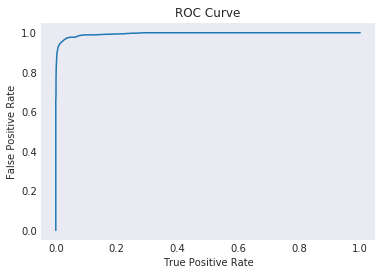

Training set areaUnderROC: 0.9953306973953445


In [14]:
trainingSummary = lr_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [20]:
# trainingSummary

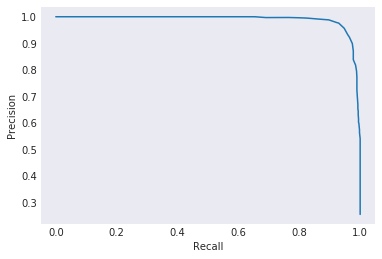

In [15]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [16]:
BalancingRatio = numNegatives / dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.7443835616438356


In [20]:
from pyspark.sql.functions import when

trainDF = trainDF.withColumn("classWeights", when(trainDF.y == 1,BalancingRatio).otherwise(1 - BalancingRatio))
trainDF.select("classWeights").show(5)

+-------------------+
|       classWeights|
+-------------------+
|0.25561643835616443|
|0.25561643835616443|
|0.25561643835616443|
|0.25561643835616443|
|0.25561643835616443|
+-------------------+
only showing top 5 rows



In [21]:
start = time.time()
lr1 = LogisticRegression(featuresCol = 'features', labelCol='y', weightCol="classWeights", maxIter=10, regParam=1)
lr_model1 = lr1.fit(trainDF)
lr_train_predictions1 = lr_model1.transform(trainDF)
lr_valid_predictions1 = lr_model1.transform(validDF)

lr_valid_predictions1.select("y","prediction").show(10)

print(f"\n... Executed in {time.time() - start} seconds")

+---+----------+
|  y|prediction|
+---+----------+
|0.0|       0.0|
|0.0|       0.0|
|0.0|       0.0|
|0.0|       1.0|
|0.0|       1.0|
|0.0|       0.0|
|0.0|       0.0|
|0.0|       0.0|
|0.0|       1.0|
|0.0|       1.0|
+---+----------+
only showing top 10 rows


... Executed in 183.40077424049377 seconds


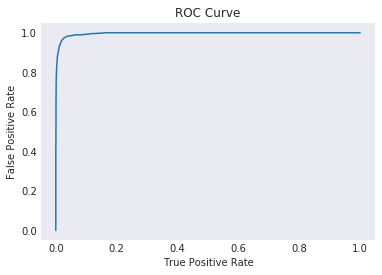

Training set areaUnderROC: 0.9963034934265262


In [22]:
trainingSummary1 = lr_model1.summary
roc1 = trainingSummary1.roc.toPandas()
plt.plot(roc1['FPR'],roc1['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary1.areaUnderROC))

In [24]:
start = time.time()
lr_evaluator1 = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction",metricName="areaUnderPR")

trainAUPR = lr_evaluator1.evaluate(lr_train_predictions1)
validAUPR = lr_evaluator1.evaluate(lr_valid_predictions1)
print(f"Area Under Precision Recall Curve on Train data = {trainAUPR}")
print(f"Area Under Precision Recall Curve on Validation data = {validAUPR}")
print(f"\n... Executed in {time.time() - start} seconds")

Area Under Precision Recall Curve on Train data = 0.8588076212236445
Area Under Precision Recall Curve on Validation data = 0.3485420679247596

... Executed in 201.79748034477234 seconds


In [28]:
trainDF = sqlContext.read.parquet('train_for_model.parquet')
testDF = sqlContext.read.parquet('test_for_model.parquet')

In [29]:
sampleDF1 = trainDF.sample(False, 0.001, seed=1234) # Approximately 36500 records

In [30]:
trainDF, validDF = sampleDF1.randomSplit([0.8,0.2], seed = 1)

In [31]:
dataset_size = trainDF.count()
numPositives = trainDF.select("y").where('y == 1').count()
per_ones = (float(numPositives) / float(dataset_size)) * 100
numNegatives = float(dataset_size - numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 9247
Percentage of ones are 25.34257838193379


In [32]:
dataset_size

36488

# K Fold Cross Validation

In [ ]:
start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol='y', maxIter=10**4)
    
# Train the 10-fold Cross Validator
cvModel = CrossValidator(estimator=Pipeline(stages = [lr]),
            estimatorParamMaps=ParamGridBuilder() \
                                .addGrid(lr.regParam, [10.0, 7.5, 5.0, 2.5, 1.0, 0.1]) \
                                .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 0.8, 1.0]) \
                                .build(),
            evaluator=BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction",metricName="areaUnderPR"),numFolds=10).fit(trainDF)

print(f"\n... Executed in {time.time() - start} seconds")

In [ ]:
regParam = cvModel.bestModel.stages[-1]._java_obj.getRegParam()
maxIter = cvModel.bestModel.stages[-1]._java_obj.getMaxIter()
elasticNetParam = cvModel.bestModel.stages[-1]._java_obj.getElasticNetParam()
print("Best Model Parameters:")
print(f"Reg Param: {regParam}, Max Iterations: {maxIter}, Elastic Net Param: {elasticNetParam}")

After running the logistic regression grid search, from the selected parameters we saw the best model using a regularization parameter of 1, and an elastic net parameter of 0.  We can continue to refine our regularization parameter by running another grid search over a smaller area.

In [ ]:
start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol='y', maxIter=10**4)
    
# Train the 10-fold Cross Validator
cvModel = CrossValidator(estimator=Pipeline(stages = [lr]),
            estimatorParamMaps=ParamGridBuilder() \
                                .addGrid(lr.regParam, [2.0, 1.75, 1.50, 1.25, 1.0, 0.75, 0.50]) \
                                .build(),
            evaluator=BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction",metricName="areaUnderPR"),numFolds=10).fit(trainDF)

print(f"\n... Executed in {time.time() - start} seconds")

In [ ]:
start = time.time()
cvModel.bestModel.save("best_model")
print(f"\n... Executed in {time.time() - start} seconds")

In [ ]:
start = time.time()
trainPredsAndLabels = cvModel.transform(trainDF)
validPredsAndLabels = cvModel.transform(validDF)
testPredsAndLabels = cvModel.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")

In [ ]:
regParam = cvModel.bestModel.stages[-1]._java_obj.getRegParam()
maxIter = cvModel.bestModel.stages[-1]._java_obj.getMaxIter()
elasticNetParam = cvModel.bestModel.stages[-1]._java_obj.getElasticNetParam()
print("Best Model Parameters:")
print(f"Reg Param: {regParam}, Max Iterations: {maxIter}, Elastic Net Param: {elasticNetParam}")

# Evaluate Our Best Model with Selected Metrics

In [ ]:
def evaluateModel(predictionAndLabels):
    
    resultsDict = dict()
    
    # Area Under ROC
    evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName="areaUnderROC")
    areaUnderROC = evaluator.evaluate(predictionAndLabels)    
    print(f"Area under ROC = {areaUnderROC}")
    resultsDict['areaUnderROC'] = areaUnderROC

    # Area Under PR
    evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName='areaUnderPR')
    areaUnderPR = evaluator.evaluate(predictionAndLabels)
    print(f"Area under PR = {areaUnderPR}")
    resultsDict['areaUnderPR'] = areaUnderPR

    # Metrics
    predictionRDD = predictionAndLabels.select(['y', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)

    # Confusion Matrix
    print(metrics.confusionMatrix().toArray())

    # Overall statistics
    precision = metrics.precision()
    resultsDict['precision'] = precision
    
    recall = metrics.recall()
    resultsDict['recall'] = recall
    
    fscore = metrics.fMeasure()
    resultsDict['F Score'] = fscore
        
    print(f"Precision: {precision}, Recall: {recall}, F Score: {fscore}")
            
    # Statistics by class
    labels = [0.0, 1.0]
    for label in sorted(labels):
        resultsDict[label] = {}
        resultsDict[label]['precision'] = metrics.precision(label)
        resultsDict[label]['recall'] = metrics.recall(label)
        resultsDict[label]['F1 Measure'] = metrics.fMeasure(label, beta=1.0)
        print(f"Class {label}: Precision: {resultsDict[label]['precision']}, Recall: {resultsDict[label]['recall']}, F Score: {resultsDict[label]['F1 Measure']}")

    return resultsDict

In [ ]:
start = time.time()
trainResultDict = evaluateModel(trainPredsAndLabels)
print(f"\n... Executed in {time.time() - start} seconds")

In [ ]:
start = time.time()
validResultDict = evaluateModel(validPredsAndLabels)
print(f"\n... Executed in {time.time() - start} seconds")

# Submit Our Test Set to Kaggle To See Performance

In [ ]:
from pyspark.sql.window import Window as W
kaggleOutput = testPredsAndLabels.withColumn("idx", F.monotonically_increasing_id())
w = W.orderBy("idx")
kaggleOutput = kaggleOutput.withColumn("index", F.row_number().over(w))
kaggleOutput = kaggleOutput.drop("idx")

In [ ]:
kaggleOutput = kaggleOutput.select(["index", "probability"])

In [ ]:
df.toPandas().to_csv('mycsv.csv')

In [ ]:
df.save('mycsv.csv', 'com.databricks.spark.csv')

In [ ]:
df.write.format('com.databricks.spark.csv').save('mycsv.csv')

In [ ]:
def toCSVLine(data):
  return ','.join(str(d) for d in data)

In [ ]:
kaggleOutput.rdd.map(lambda x: (x['index'], x['probability'][0])).map(toCSVLine).take(5)

In [ ]:
start = time.time()
lines = kaggleOutput.rdd.map(lambda x: (x['index'], x['probability'][0])).toDF()
print(f"\n... Executed in {time.time() - start} seconds")

In [ ]:
lines.take(5)

In [ ]:
start = time.time()
with open("submission.csv", w):
    file.write("Id,Predicted\n")
    for data in kaggleSubmissionList:
        file.write(f"{data[0]},{data[1]}\n")
print(f"\n... Executed in {time.time() - start} seconds")

In [ ]:
!kaggle competitions list

In [ ]:
!kaggle competitions submit -c criteo-display-ad-challenge -f submission.csv -m "Test Submission"


# Comparison between CSV & Parquet

Apache parquet file format is designed to more efficiently store columnar data rather than by row such as using a file format like csv.  Parquet is optimized to minimize file I/O and efficiently compresses.  Parquet can be queried more efficiently with SQL than csv files.  When using a cloud platform, users may be charged by I/O so use of a csv will be more expensive when compared to parquet.  Additionally, because parquet is faster, computation charges are correspondingly lower as well.  Parquet file format may yield a performance improvement around 10x, or an order of magnitude, when compared to performance on a csv.

Additionally, parquet file format allows for easy use of a spark DF as it has performance improvements relative to RDD.  

https://dzone.com/articles/how-to-be-a-hero-with-powerful-parquet-google-and  
https://developer.ibm.com/hadoop/2016/01/14/5-reasons-to-choose-parquet-for-spark-sql/  
https://mapr.com/blog/tips-and-best-practices-to-take-advantage-of-spark-2-x/  

# ML Lib Use  

In this project we will leverage the MLlib RDD based API to perform machine learning algorithms on our dataset

https://spark.apache.org/docs/latest/mllib-guide.html  

# What is Evaluation Metric and how does this matter wrt over & under sampling?

We use area under the curve.

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Course Concepts

# __Section 1__ - Question Formulation

# __Section 2__ - Algorithm Explanation

# __Section 3__ - EDA & Challenges

# __Section 4__ - Algorithm Implementation

# __Section 5__ - Course Concepts